# 2. Real Estate Investment Prediction: Exploratory Data Analysis

## 2.1 Introduction

We now have several databases at our disposal. 
- We have a database containing all of the houses for sale in our target area, including information such as their location, price (including tax and HOA), and characteristics;
- We have another database containing 115 homes owned by a corporate entity (called Houses Inc. for this study) including their location, square footage, beds/baths and monthly rent (and we are assuming that they are making a profit on these houses per some capitalization period, which we consider to be monthly ROI);
- Finally we have a database of schools, which contains the school's geographical location, the demographic breakdown, and some indicators of the student's academic success. 


Does Houses Inc. select houses in areas with certain demographics? Does the proximity to a 'good' school versus a 'bad' school affect the rent Houses Inc. can charge? 


## 2.2 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import process, fuzz
from turfpy.measurement import boolean_point_in_polygon
import turfpy as turf
from geojson import Point, MultiPolygon, Feature
import shapely
from warnings import filterwarnings
import re
import decimal
import requests
import json
import time

Use a little CSS to make the dataframes throughout the notebook a little more readable. 

In [2]:
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>

## 2.3 API URL and Headers

In [27]:
url = "https://realty-mole-property-api.p.rapidapi.com/salePrice"
headers = {
    'x-rapidapi-key': "",
    'x-rapidapi-host': "realty-mole-property-api.p.rapidapi.com"
    }

## 2.4 Fuzzywuzzy function

In [28]:
# Later in the notebook, we will use this function to match district names between databases (some use the words
# 'school district', some don't; some names are obsolete, replaced with a new name by the Colorado department of education)
def match_names(array1, array2, lim):
    """
    Function to match two series and produce a match and the score if over a certain threshold, else
    generate a 'none found'
    """
    shape_name = []
    similarity = []

    for i in array1:
        ratio = process.extract(i, array2, scorer=fuzz.partial_ratio, limit=1)
        if ratio[0][1] >= lim:
            shape_name.append(ratio[0][0])
            similarity.append(ratio[0][1])
        else:
            shape_name.append('none found')
            similarity.append('none')
        
        
    return pd.Series(shape_name), pd.Series(similarity)


## 2.5 Load The Data

### 2.5.1 Shape file with geometry of school districts

We have demographics by school, a list of schools for each district, and have access to a shape file with the geometry of the districts. 
What we *don't* have is the school district for each house owned by Houses Inc. We do have the lat-long of each house, however. 
A way to match the house to the district is to place the geometric point of the house inside a polygon of the district.

To start, let's load the shape file with the geometry of the districts. 

In [29]:
# Read in the shape file of district geo info from colorado.data.gov
district_gpd = gpd.read_file('../raw_data/geo_export_972ae359-f768-49c7-9ef8-5465d24f44a8.shp')
district_gpd.head(2)

,abbrev_nam,alt_addres,lgid,lgname,lgstatusid,lgtypeid,mail_addre,mail_city,mail_state,mail_zip,prev_name,source,url,geometry
0,Buena Vista R-31 School District,NA,08900,Buena Vista R-31 School District,1,99,PO Box 2027,Buena Vista,CO,81211,NA,Census TIGER SHP 2014,NA,"POLYGON ((-106.59904 39.03628, -106.59895 39.0..."
1,Burlington RE-6J School District,NA,64929,Burlington RE-6J School District,1,99,PO Box 369,Burlington,CO,80807,NA,Census TIGER SHP 2014,www.burlingtonk12.org,"POLYGON ((-102.43672 39.58525, -102.41964 39.5..."


As mentioned above, we need to standardize the names of the districts across any dataframes which use district as a field. We will use the field, 'lgname' (legal name) instead of 'abbrev_nam', so we can drop the 'abbrev_nam', and 'alt_addres' columns to avoid any confusion. The correct basis for districts for the rest of the project will be the 'lgname' column in the district_gpd dataframe, renamed to 'districtMatch'.

In [30]:
# Check to see if the prev_name column contains any useful data; if it only contains NA we can remove, otherwise leave
district_gpd['prev_name'].unique()

array(['NA', 'Maher 50(J) School District',
       'Pueblo City 60 School District',
       'Northglenn-Thornton 12 School District'], dtype=object)

In [31]:
# Drop confusing columns in place
district_gpd.drop(['abbrev_nam', 'alt_addres', 'url'], axis=1, inplace=True)

In [32]:
# Rename column
district_gpd.rename(columns = {'lgname':'districtMatch'}, inplace = True)
district_gpd.head(2)

,lgid,districtMatch,lgstatusid,lgtypeid,mail_addre,mail_city,mail_state,mail_zip,prev_name,source,geometry
0,08900,Buena Vista R-31 School District,1,99,PO Box 2027,Buena Vista,CO,81211,NA,Census TIGER SHP 2014,"POLYGON ((-106.59904 39.03628, -106.59895 39.0..."
1,64929,Burlington RE-6J School District,1,99,PO Box 369,Burlington,CO,80807,NA,Census TIGER SHP 2014,"POLYGON ((-102.43672 39.58525, -102.41964 39.5..."


### 2.5.2 Schools data

In [33]:
# read the locally stored csv into a dataframe
schools = pd.read_csv('../data/school_digger.csv')

In [34]:
schools.columns

Index(['schoolid', 'schoolName', 'lowGrade', 'highGrade', 'schoolLevel',
       'rankMovement', 'hasBoundary', 'street', 'city', 'state', 'zip', 'zip4',
       'latitude', 'longitude', 'countyName', 'districtName', 'index',
       'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents', 'pupilTeacherRatio', 'year'],
      dtype='object')

In [35]:
# This code is left for possible future use, but is not being used at this time. 

# Add a point-pair for geographical location
#schools['point_pair'] = schools.apply(lambda x:[x.longitude, x.latitude], axis=1)
#schools.head(2)

In [36]:
# Make a geodataframe from the schools df lat and longitude. 
df = pd.DataFrame(schools[['schoolid', 'latitude', 'longitude']])
schools_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [37]:
schools_gpd.head()

,schoolid,latitude,longitude,geometry
0,80336000305,39.67610,-105.026500,POINT (-105.02650 39.67610)
1,80336001750,39.76750,-105.015500,POINT (-105.01550 39.76750)
2,80555001872,39.85729,-104.958167,POINT (-104.95817 39.85729)
3,80345000436,39.55740,-104.894900,POINT (-104.89490 39.55740)
4,80195000010,39.82810,-104.900400,POINT (-104.90040 39.82810)


In [38]:
# Create a dataframe from the spatial join the schools_gpd (a geodataframe) and the district_gpd (another geodataframe)
# The goal here is to determine the district for each school using gpd.sjoin, which is a spatial join. 
# Per stack overflow, the CRS mismatch seems to be a bug. 

merging = gpd.sjoin(schools_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')

<ipython-input-38-e0aef38074a0>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merging = gpd.sjoin(schools_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')


In [39]:
# Replace the district names in schools df with the district names used in the merging dataframe - this way the district names 
# become more standardized across our data. 
schools['districtMatch'] = merging['districtMatch']
schools.drop(['districtName', 'index'], axis=1, inplace=True)
schools.columns

Index(['schoolid', 'schoolName', 'lowGrade', 'highGrade', 'schoolLevel',
       'rankMovement', 'hasBoundary', 'street', 'city', 'state', 'zip', 'zip4',
       'latitude', 'longitude', 'countyName', 'numberOfStudents',
       'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
       'percentofAsianStudents', 'percentofHispanicStudents',
       'percentofWhiteStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'pupilTeacherRatio', 'year', 'districtMatch'],
      dtype='object')

In [40]:
schools.head()

,schoolid,schoolName,lowGrade,highGrade,schoolLevel,rankMovement,hasBoundary,street,city,state,...,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofWhiteStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,pupilTeacherRatio,year,districtMatch
0,80336000305,Abraham Lincoln High School,9,12,High,-12.0,True,2285 South Federal Boulevard,Denver,CO,...,4.02,2.88,88.36,2.99,1.24,0.00,0.51,14.9,2020.0,Denver County 1 School District
1,80336001750,Academia Ana Marie Sandoval,PK,6,Elementary,-13.0,True,3655 Wyandot Street,Denver,CO,...,0.24,2.13,61.23,33.10,0.47,0.00,2.84,20.4,2020.0,Denver County 1 School District
2,80555001872,Academy High School,9,12,High,-14.0,True,8970 York Street,Thornton,CO,...,1.07,1.07,85.01,9.42,0.21,0.00,3.21,20.9,2020.0,Mapleton 1 School District
3,80345000436,Acres Green Elementary School,PK,6,Elementary,-57.0,True,13524 North Acres Green Drive,Littleton,CO,...,0.41,18.86,22.72,49.09,0.61,0.41,7.91,15.9,2020.0,Douglas County RE 1 School District
4,80195000010,Adams City High School,9,12,High,-22.0,True,7200 Quebec Parkway,Commerce City,CO,...,1.92,0.35,87.97,8.13,0.41,0.17,1.05,21.3,2020.0,Adams County 14 School District


In [41]:
schools['districtMatch'].nunique()

20

In [42]:
# Create a mask of all of the districts contained in our list of schools, within our geographical area, and filter the geoframe
# by that mask. 
m = district_gpd['districtMatch'].isin(schools.districtMatch)
district_gpd = district_gpd[m]
district_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 12 to 176
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lgid           20 non-null     object  
 1   districtMatch  20 non-null     object  
 2   lgstatusid     20 non-null     object  
 3   lgtypeid       20 non-null     object  
 4   mail_addre     20 non-null     object  
 5   mail_city      20 non-null     object  
 6   mail_state     20 non-null     object  
 7   mail_zip       20 non-null     object  
 8   prev_name      20 non-null     object  
 9   source         20 non-null     object  
 10  geometry       20 non-null     geometry
dtypes: geometry(1), object(10)
memory usage: 1.9+ KB


### 2.5.3 Load Houses Inc. data

In [43]:
# Load houses_inc df resulting from webscraping in section 1, Data Wrangling
houses_inc = pd.read_csv('../data/corporate_properties.csv')

In [44]:
houses_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_code  188 non-null    int64  
 1   address_1      188 non-null    object 
 2   city           188 non-null    object 
 3   state          188 non-null    object 
 4   zipcode        188 non-null    int64  
 5   beds           188 non-null    int64  
 6   baths          188 non-null    float64
 7   sqft           188 non-null    int64  
 8   market_rent    188 non-null    float64
 9   lat            188 non-null    float64
 10  lng            188 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 16.3+ KB


In [45]:
houses_inc.head(2)

,property_code,address_1,city,state,zipcode,beds,baths,sqft,market_rent,lat,lng
0,10000616,10433 Holland Pl,Westminster,CO,80021,3,1.5,1144,2199.0,39.88250,-105.10441
1,10000753,10627 Kittredge St,Commerce City,CO,80022,3,2.5,1993,2939.0,39.88982,-104.80151


To find the district each house is placed within, we need to generate a geodataframe from this dataframe. 

In [46]:
# Make a geodataframe from the houses, inc lat and longitude. 
df = pd.DataFrame(houses_inc[['property_code', 'lat', 'lng']])
house_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
house_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   property_code  188 non-null    int64   
 1   lat            188 non-null    float64 
 2   lng            188 non-null    float64 
 3   geometry       188 non-null    geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 6.0 KB


In [47]:
# Create the dataframe from the spatial join, so that we can place the houses spatially within a district. 

merging = gpd.sjoin(house_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')

<ipython-input-47-fec8d574d155>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merging = gpd.sjoin(house_gpd, district_gpd[['districtMatch', 'geometry']], how='left', op='within')


In [48]:
# Add the series containing district information to the houses_inc df
houses_inc['districtMatch'] = merging['districtMatch']
houses_inc.shape

(188, 12)

We need to know the approximate value of the houses_inc homes in order to figure out the cost of ownership. Due to the difficulty of using Zillow and getting "zestimates" (Zillow aggressively deters webscraping), we will use a paid API called Realty Mole which has a utility which estimates values. It seems to slightly underestimate the values based on the "zestimate" but it seems to be based on comps. 

In [49]:
# Call API for each row using longitude and latitude of the corporate owned houses. 
# The API has a max call on the data plan, so use sleep to slow it down
print("Start:", time.ctime())
prices = []
for row in houses_inc.itertuples():
    querystring = {'longitude':row.lng, 'latitude':row.lat}
    response = requests.request("GET", url, headers=headers, params=querystring)
    res = json.loads(response.text)
    # Read price out of json and append to list, 'prices'
    prices.append(res['price'])
    time.sleep(1)
print("End:", time.ctime())

Start: Thu Sep  2 13:49:59 2021
End: Thu Sep  2 13:55:19 2021


In [50]:
# Make list a new column in houses_inc df.     
houses_inc['estimatedPrice'] = prices
houses_inc.head()

,property_code,address_1,city,state,zipcode,beds,baths,sqft,market_rent,lat,lng,districtMatch,estimatedPrice
0,10000616,10433 Holland Pl,Westminster,CO,80021,3,1.5,1144,2199.0,39.88250,-105.10441,Jefferson County R-1 School District,452333.33
1,10000753,10627 Kittredge St,Commerce City,CO,80022,3,2.5,1993,2939.0,39.88982,-104.80151,Brighton 27J School District,503300.00
2,10000801,10705 Clermont St,Thornton,CO,80233,3,2.0,1544,2529.0,39.89058,-104.93351,Adams 12 Five Star Schools,418283.33
3,10000898,10874 Fairfax Way,Thornton,CO,80233,4,2.0,1904,2599.0,39.89348,-104.92838,Adams 12 Five Star Schools,431633.33
4,10000946,10944 Bellaire Way,Thornton,CO,80233,4,2.0,1800,2485.0,39.89548,-104.93625,Adams 12 Five Star Schools,428333.33


In [52]:
# Write the modified Houses Inc dataframe back to local storage
houses_inc.to_csv('../data/corporate_properties_values.csv', index = False, header = True)

In [53]:
# Read the data from the file into a new df (don't want to re-run API if the Notebook is re-opened - start here)
houses_inc_values = pd.read_csv('../data/corporate_properties_values.csv')

In [54]:
district_rents_means = houses_inc_values.groupby('districtMatch')[['market_rent', 'sqft']].agg(np.mean)\
                                        .round(2)
print(district_rents_means)

                                        market_rent     sqft
districtMatch                                               
Adams 12 Five Star Schools                  2573.92  1781.33
Adams-Arapahoe 28J School District          2485.54  1841.54
Brighton 27J School District                2580.71  2015.43
Cherry Creek 5 School District              2561.33  1843.19
Denver County 1 School District             2468.87  1732.96
Douglas County RE 1 School District         2616.88  1906.68
Jefferson County R-1 School District        2573.44  1645.78
Littleton 6 School District                 2774.50  2139.00
Mapleton 1 School District                  2493.00  1998.60
St. Vrain Valley RE 1J School District      2907.00  2321.00
Westminster 50 School District              2564.67  1821.00


### 2.5.4 Houses for sale data

Load the houses for sale data, which was scraped from a denver listings website using the same long/lat we have used for schools, districts, and corporate-owned properties. 

In [55]:
for_sale = pd.read_csv('../data/denverlistings.csv', thousands=',')

In [56]:
for_sale.shape, for_sale['listPrice'].min()

((691, 17), 235000)

In [57]:
# Drop records where taxes are unknown or are less than $500
for_sale.dropna(subset=['taxes'], inplace=True)
for_sale.shape, for_sale.taxes.min()

((689, 17), '$0')

There are currently 878 single family homes for sale in our dataframe (between 200 and 750k, intended to remove mobile homes and outliers) in this geographical region. 

In [58]:
# Remove the '$' from listPrice, taxes, and hoaFees.
for_sale.taxes = [x.strip('$') for x in for_sale.taxes]
for_sale.taxes = [x.replace(',', '') for x in for_sale.taxes]

# The below method is really cool, but can't be repeated, because it slices off the first character. 
#for_sale.taxes = [x[1:] for x in for_sale.taxes]
# So, instead strip off the '$' using a simple list comp
for_sale.hoaFees = [x.strip('$') for x in for_sale.hoaFees]
for_sale.hoaFees = [x.replace(',', '') for x in for_sale.hoaFees]
for_sale.head()

,Unnamed: 0,address,city,zip,beds,baths,sqft,listPrice,taxes,hoaFees,hoaFreq,lat,lng,district,elementarySchool,middleSchool,highSchool
0,0,2920 Benton Street,Wheat Ridge,80214,4.0,2.0,1751,750000,1664,0,NaN,39.759313,-105.055104,Jefferson County R-1,Lumberg,Jefferson,Jefferson
1,1,1305 E Iowa Avenue,Denver,80210,3.0,3.0,1615,750000,2749,0,NaN,39.687801,-104.971911,Denver 1,Asbury,Grant,South
2,2,3233 N Gilpin Street,Denver,80205,3.0,2.0,1583,750000,2205,0,NaN,39.762607,-104.967457,Denver 1,Cole Arts And Science Academy,Wyatt,Manual
3,3,2634 Dahlia Street,Denver,80207,5.0,2.0,1104,750000,2354,0,NaN,39.755537,-104.931366,Denver 1,Stedman,Bill Roberts E-8,East
4,4,3112 S Monaco Circle,Denver,80222,4.0,3.0,3099,750000,3754,0,NaN,39.659757,-104.913892,Cherry Creek 5,Holly Hills,West,Cherry Creek


In [59]:
# Correct some of the strange data types left over from scraping
for_sale.hoaFees = for_sale.hoaFees.astype(int)
for_sale.taxes = for_sale.taxes.astype(int)
for_sale.dtypes

Unnamed: 0            int64
address              object
city                 object
zip                   int64
beds                float64
baths               float64
sqft                  int64
listPrice             int64
taxes                 int32
hoaFees               int32
hoaFreq              object
lat                 float64
lng                 float64
district             object
elementarySchool     object
middleSchool         object
highSchool           object
dtype: object

In [60]:
# check the tax values to make sure they make sense; taxes should not be $0 or $1, which are placeholders. Remove those records.
for_sale = for_sale[for_sale['taxes'] > 1]
for_sale['taxes'].min(), for_sale.shape

(483, (667, 17))

Change the HOA figure into monthly dollar amount. 

In [61]:
monthly_hoa = []

for row in for_sale.itertuples():
    x = 0
    if row.hoaFees != 0:
        if row.hoaFreq == 'Monthly':
            x = 1 * row.hoaFees
        if row.hoaFreq == 'Quarterly':
            x = row.hoaFees/3
        if row.hoaFreq == 'Semi-Annually':
            x = row.hoaFees/6
        if row.hoaFreq == 'Annually':
            x = row.hoaFees/12
    
    monthly_hoa.append(x)
    
for_sale['monthly_hoa'] = monthly_hoa

In [62]:
# Match the for_sale df 'district' to the district name in the shapefile df of districts.
for_sale['districtMatch'], for_sale['similarity'] = match_names(for_sale.district, district_gpd.districtMatch, 70)

In [63]:
# Drop the 'district' col, keep the districtMatch col. 
for_sale.drop(['district', 'similarity', 'hoaFees', 'hoaFreq', 'elementarySchool', 'middleSchool', 'highSchool', 'Unnamed: 0'], 
              axis=1, inplace=True)

In [64]:
for_sale.tail()

,address,city,zip,beds,baths,sqft,listPrice,taxes,lat,lng,monthly_hoa,districtMatch
686,3190 W 66th Avenue,Denver,80221,2.0,1.0,828,299000,1259,39.816240,-105.028828,0.0,NaN
687,10355 E 23rd Avenue,Aurora,80010,3.0,1.0,768,280000,2509,39.751223,-104.867264,0.0,NaN
688,3464 W Alaska Place,Denver,80219,1.0,1.0,598,270000,606,39.708266,-105.032956,0.0,NaN
689,2301 Galena Street,Aurora,80010,2.0,1.0,816,267000,2606,39.751224,-104.869603,0.0,NaN
690,3301 S Zuni Street,Englewood,80110,1.0,1.0,420,235000,1134,39.656756,-105.016124,0.0,NaN


Because there are a significant amount (~20%) of houses for sale with hoa fees of some kind, we will leave these records in the data and set them to the side. We do not have the HOA monthlies (if any) for the houses owned by the corporation, so the machine learning model will not be able to incorporate this feature. Instead, we will subtract the HOA from the predicted monthly rent in the final step of determining ROI for the possible investment properties. 

In [65]:
for_sale[for_sale['monthly_hoa']>0].count()

address          97
city             97
zip              97
beds             97
baths            97
sqft             97
listPrice        97
taxes            97
lat              97
lng              97
monthly_hoa      97
districtMatch    97
dtype: int64

In [66]:
# Write the modified Houses Inc dataframe back to local storage
for_sale.to_csv('../data/for_sale_cleaned.csv', index = False, header = True)

## 2.5 Explore the Data

### 2.5.1 Scatter plot of the schools, and houses owned by Houses, Inc.

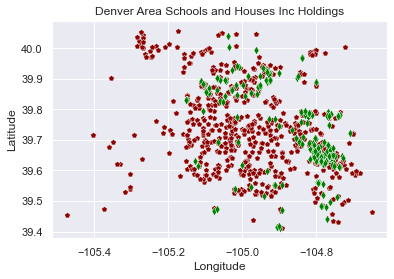

In [67]:
# Start with a scatterplot of the locations of schools.
sns.set()
sns.scatterplot(x='longitude', y='latitude', data=schools,
                color='darkred', marker='p')
sns.scatterplot(x='lng', y='lat', data=houses_inc_values,
                 color='green', marker='d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Denver Area Schools and Houses Inc Holdings')
plt.show()

Certainly there is nothing interesting except that houses are near schools, which is a universal truth. Maybe the school district is more important that the location. Let's overlay this on top of the school district. 

<Figure size 720x504 with 0 Axes>

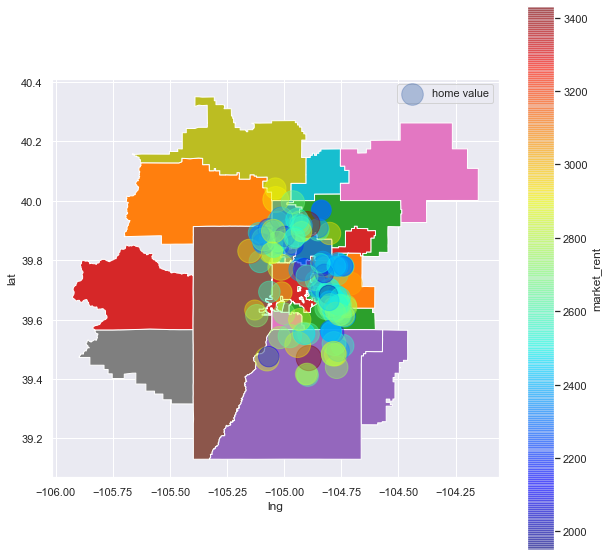

In [70]:
plt.figure(figsize=(10,7))
ax = district_gpd.plot(column='districtMatch', legend=True, figsize=(10,10))

houses_inc_values.plot(x='lng', y='lat', kind='scatter', alpha=0.4, 
         s= houses_inc_values['estimatedPrice']/1000, label='home value', ax=ax,
         c= 'market_rent', cmap=plt.get_cmap('jet'), colorbar=True, 
         zorder=5)
plt.legend()
plt.show()

No handles with labels found to put in legend.


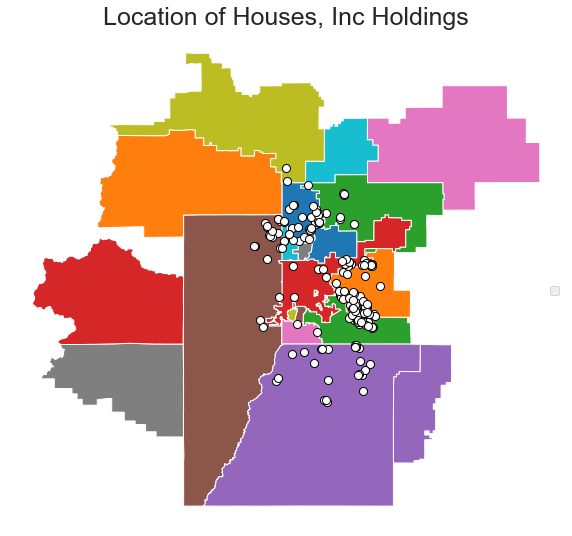

In [71]:
sns.set()
# Plot the district shapefile
ax = district_gpd.plot(column='districtMatch', legend=True, figsize=(10,10))
ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set_axis_off()
# Add the house locations
plt.scatter(x=houses_inc_values.lng, y=houses_inc_values.lat, c='white', edgecolor = 'black', s=65)
# Add labels and title
plt.title('Location of Houses, Inc Holdings', fontsize=25)
plt.xlabel('longitude')
plt.ylabel('latitude')

# Add grid lines and show the plot
#plt.grid()
plt.show()

### 2.5.3 Plot the House Inc boxplots to look at variance

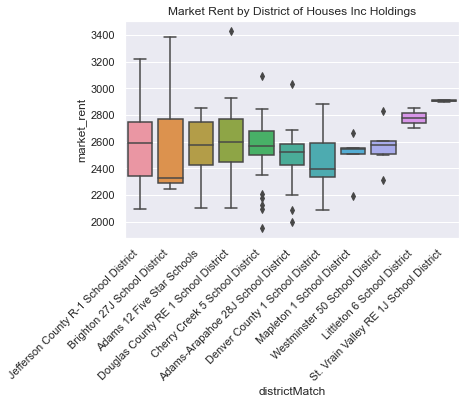

In [72]:
_ = sns.boxplot(x='districtMatch', y='market_rent', data=houses_inc_values)
plt.title('Market Rent by District of Houses Inc Holdings')
_.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right');

### 2.5.4 Houses Inc properties per district, and median rent charged by school district

Now that we have the district information for each house owned by Houses Inc, we can find the average market rent by district and the number of houses owned in each district. 

In [74]:
# Create a pivot table of median rent per district
pivot = houses_inc_values.pivot_table(index =['districtMatch'], values=['market_rent'],
                       aggfunc ='median')

pivot_valuation = houses_inc_values.pivot_table(index=['districtMatch'], values=['estimatedPrice'], aggfunc = 'median')
pivot_full = pivot.merge(pivot_valuation, on='districtMatch')

print(pivot_full)

                                        market_rent  estimatedPrice
districtMatch                                                      
Adams 12 Five Star Schools                   2574.5      435650.000
Adams-Arapahoe 28J School District           2525.0      399529.815
Brighton 27J School District                 2325.0      401666.670
Cherry Creek 5 School District               2567.5      406150.000
Denver County 1 School District              2395.0      411666.670
Douglas County RE 1 School District          2599.0      494333.330
Jefferson County R-1 School District         2591.5      450316.665
Littleton 6 School District                  2774.5      484796.665
Mapleton 1 School District                   2545.0      405185.000
St. Vrain Valley RE 1J School District       2907.0      565650.000
Westminster 50 School District               2572.5      415666.665


The district with the highest market rents is St. Vrain, and the lowest is Brighton. St. Vrain also has the highest estimated value. Brighton is within .25% of the lowest housing value. It seems that market_rent may be closely tied to home value. 

In [75]:
# Create a grouby of houses per district owned by Houses Inc

houses_by_district = houses_inc_values.groupby("districtMatch")["property_code"].count().sort_values(ascending=False)                                                                                    
print(houses_by_district)

districtMatch
Cherry Creek 5 School District            48
Adams-Arapahoe 28J School District        28
Douglas County RE 1 School District       25
Adams 12 Five Star Schools                24
Denver County 1 School District           23
Jefferson County R-1 School District      18
Brighton 27J School District               7
Westminster 50 School District             6
Mapleton 1 School District                 5
Littleton 6 School District                2
St. Vrain Valley RE 1J School District     2
Name: property_code, dtype: int64


Most of the houses are in the Cherry Creek district, and the fewest are in Littleton and St. Vrain Valley. That's interesting, because those two districts fetch the highest market rent. 

Let's combine houses_by_district and pivot and make nice chart showing the correlation between market_rents and number of houses. 

In [76]:
houses_by_district = pd.DataFrame(houses_by_district)

In [77]:
houses_by_district.columns

Index(['property_code'], dtype='object')

In [78]:
houses_by_district = pivot_full.join(houses_by_district)
houses_by_district.rename(columns = {'market_rent':'medianRent', 'estimatedPrice':'estcurrentValue', 'property_code':'#propsinDistrict'},
                          inplace = True)
houses_by_district.sort_values("medianRent", ascending=False)
houses_by_district.head(10)

,medianRent,estcurrentValue,#propsinDistrict
districtMatch,,,
Adams 12 Five Star Schools,2574.5,435650.000,24
Adams-Arapahoe 28J School District,2525.0,399529.815,28
Brighton 27J School District,2325.0,401666.670,7
Cherry Creek 5 School District,2567.5,406150.000,48
Denver County 1 School District,2395.0,411666.670,23
Douglas County RE 1 School District,2599.0,494333.330,25
Jefferson County R-1 School District,2591.5,450316.665,18
Littleton 6 School District,2774.5,484796.665,2
Mapleton 1 School District,2545.0,405185.000,5


<ipython-input-79-58d4784cf10f>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(houses_by_district.index, rotation=45, horizontalalignment='right')


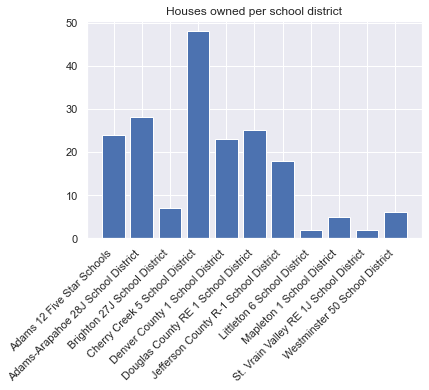

In [79]:
fig, ax = plt.subplots()
ax.bar(houses_by_district.index, houses_by_district['#propsinDistrict'])
ax.set_xticklabels(houses_by_district.index, rotation=45, horizontalalignment='right')
plt.title('Houses owned per school district')
# ax.bar(houses_by_district.index, houses_by_district['market_rent'])
plt.show();

We have the demographic information by school, the district by school, the district by houses both for sale and owned by Houses Inc. Let's aggregate the demographic data by district between the schools and a new, district_demographics dataframe. 

In [80]:
# Have the schools column names handy
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   schoolid                          569 non-null    int64  
 1   schoolName                        569 non-null    object 
 2   lowGrade                          569 non-null    object 
 3   highGrade                         569 non-null    int64  
 4   schoolLevel                       569 non-null    object 
 5   rankMovement                      569 non-null    float64
 6   hasBoundary                       569 non-null    bool   
 7   street                            569 non-null    object 
 8   city                              569 non-null    object 
 9   state                             569 non-null    object 
 10  zip                               569 non-null    int64  
 11  zip4                              555 non-null    float64
 12  latitude

In [81]:
# New df from the schools df, with only demographics and removing individual locations. 
# Maintain location information within schools df.

district_demographics = schools[['districtMatch', 'rankMovement', 'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents']]

In [82]:
# Take a look at the df we just created
district_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     569 non-null    object 
 1   rankMovement                      569 non-null    float64
 2   numberOfStudents                  569 non-null    float64
 3   percentFreeDiscLunch              568 non-null    float64
 4   percentofAfricanAmericanStudents  568 non-null    float64
 5   percentofAsianStudents            568 non-null    float64
 6   percentofHispanicStudents         568 non-null    float64
 7   percentofWhiteStudents            568 non-null    float64
 8   percentofIndianStudents           568 non-null    float64
 9   percentofPacificIslanderStudents  568 non-null    float64
 10  percentofTwoOrMoreRaceStudents    568 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


We have a breakdown of percentages of each race by district. Are these percentages reliable? Before we use this data for analysis, does the data make sense? 

In [83]:
# Add together the percentages and see if it adds to about 100%
district_demographics['totalpercent'] = schools.apply(lambda row: row['percentofAfricanAmericanStudents' : 'percentofTwoOrMoreRaceStudents'].sum(),axis=1)

<ipython-input-83-d60c276f12a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_demographics['totalpercent'] = schools.apply(lambda row: row['percentofAfricanAmericanStudents' : 'percentofTwoOrMoreRaceStudents'].sum(),axis=1)


In [84]:
# Are there any schools where it does not add to one hundred percent-ish
district_demographics[district_demographics['totalpercent'] <= 99]

,districtMatch,rankMovement,numberOfStudents,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofWhiteStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,totalpercent
522,Mapleton 1 School District,45.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


It looks there is one school without demographic information, let's delete that school. 

In [85]:
# Keep only schools with a total percentage of over 99%
district_demographics = district_demographics[district_demographics['totalpercent'] >= 99]
district_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     568 non-null    object 
 1   rankMovement                      568 non-null    float64
 2   numberOfStudents                  568 non-null    float64
 3   percentFreeDiscLunch              568 non-null    float64
 4   percentofAfricanAmericanStudents  568 non-null    float64
 5   percentofAsianStudents            568 non-null    float64
 6   percentofHispanicStudents         568 non-null    float64
 7   percentofWhiteStudents            568 non-null    float64
 8   percentofIndianStudents           568 non-null    float64
 9   percentofPacificIslanderStudents  568 non-null    float64
 10  percentofTwoOrMoreRaceStudents    568 non-null    float64
 11  totalpercent                      568 non-null    float64
dtypes: float

In [86]:
# Create pivot table adding together all of the percentages; this is a clumsy way to do it. 

districtpivot = district_demographics.pivot_table(index =['districtMatch'], values=['rankMovement', 'numberOfStudents', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofWhiteStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents'],
                       aggfunc ='sum')

In [87]:
districtpivot.head()

,numberOfStudents,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
districtMatch,,,,,,,,,,
Adams 12 Five Star Schools,31932.0,2037.58,82.02,203.19,2021.06,23.51,6.12,142.71,1821.45,-1006.0
Adams County 14 School District,5663.0,748.52,21.47,1.26,768.19,4.15,1.14,9.13,94.67,-50.0
Adams-Arapahoe 28J School District,30729.0,3345.76,703.93,227.14,2387.96,31.93,46.03,261.62,641.48,-1693.0
Boulder Valley RE 2 School District,26914.0,985.34,44.15,203.30,899.35,13.02,4.35,252.01,2883.88,-515.0
Brighton 27J School District,12897.0,792.52,39.63,52.64,967.28,5.52,3.13,53.98,677.78,-865.0


In [88]:
# Get the school counts per district, then normalize the percentages. 
schoolcount = schools.groupby("districtMatch")["schoolid"].count()
districts_df = pd.merge(districtpivot, schoolcount, on = "districtMatch", how = "outer")

district_demo_final = districts_df.loc[:,"percentFreeDiscLunch":"rankMovement"].div(districts_df["schoolid"], axis=0)

I would be interested in seeing a correlation heatmap after the houses_inc database has been joined to the demographics information. Let's join 'district_demo_final' to houses_inc on the district. First, we need to add a new column to 'district_demo_final' in order to combine them (right now district name is an index).

In [89]:
# Round the values to 2 decimal places
district_demo_final = district_demo_final.round(2)
district_demo_final.head(2)

,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
districtMatch,,,,,,,,,
Adams 12 Five Star Schools,47.39,1.91,4.73,47.00,0.55,0.14,3.32,42.36,-23.40
Adams County 14 School District,83.17,2.39,0.14,85.35,0.46,0.13,1.01,10.52,-5.56


In [90]:
# reset index on 'district_demo_final'
district_demo_final.reset_index(inplace=True)
district_demo_final.head(2)


,districtMatch,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
0,Adams 12 Five Star Schools,47.39,1.91,4.73,47.00,0.55,0.14,3.32,42.36,-23.40
1,Adams County 14 School District,83.17,2.39,0.14,85.35,0.46,0.13,1.01,10.52,-5.56


In [91]:
# Write the modified Houses Inc dataframe back to local storage
district_demo_final.to_csv('../data/district_demographics.csv', index=False, header = True)

In [92]:
houses_incValuesDemo = houses_inc_values.merge(district_demo_final, how = 'left', 
                                                        on =['districtMatch'])
houses_incValuesDemo.columns

Index(['property_code', 'address_1', 'city', 'state', 'zipcode', 'beds',
       'baths', 'sqft', 'market_rent', 'lat', 'lng', 'districtMatch',
       'estimatedPrice', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement'],
      dtype='object')

In [93]:
# Write the modified Houses Inc dataframe back to local storage
houses_incValuesDemo.to_csv('../data/corporate_properties_values_Demo.csv', index = False, header = True)

In [94]:
# merge the demographics with the for_sale database too
for_sale_demographics = for_sale.merge(district_demo_final, how='left', on=['districtMatch'])
for_sale_demographics.shape

(667, 21)

In [95]:
# write the modified for_sale dataframe back to local storage
for_sale_demographics.to_csv('../data/for_sale_Demo.csv', index=False, header=True)

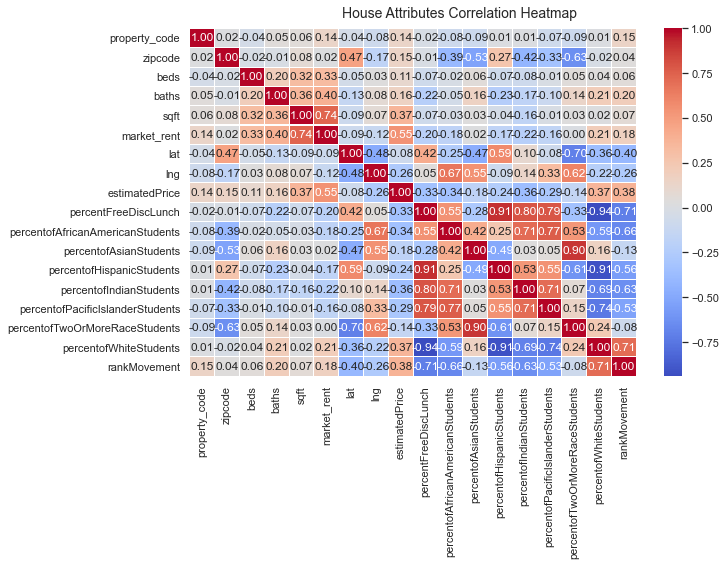

In [96]:
f, ax = plt.subplots(figsize=(10, 6))
corr = houses_incValuesDemo.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap = "coolwarm", fmt='.2f', linewidth=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('House Attributes Correlation Heatmap', fontsize=14)

In [97]:
houses_by_district.head()

,medianRent,estcurrentValue,#propsinDistrict
districtMatch,,,
Adams 12 Five Star Schools,2574.5,435650.000,24
Adams-Arapahoe 28J School District,2525.0,399529.815,28
Brighton 27J School District,2325.0,401666.670,7
Cherry Creek 5 School District,2567.5,406150.000,48
Denver County 1 School District,2395.0,411666.670,23


In [98]:
houses_by_district.reset_index(inplace=True)

In [99]:
houses_by_district.head()

,districtMatch,medianRent,estcurrentValue,#propsinDistrict
0,Adams 12 Five Star Schools,2574.5,435650.000,24
1,Adams-Arapahoe 28J School District,2525.0,399529.815,28
2,Brighton 27J School District,2325.0,401666.670,7
3,Cherry Creek 5 School District,2567.5,406150.000,48
4,Denver County 1 School District,2395.0,411666.670,23


In [100]:
district_demo_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   districtMatch                     20 non-null     object 
 1   percentFreeDiscLunch              20 non-null     float64
 2   percentofAfricanAmericanStudents  20 non-null     float64
 3   percentofAsianStudents            20 non-null     float64
 4   percentofHispanicStudents         20 non-null     float64
 5   percentofIndianStudents           20 non-null     float64
 6   percentofPacificIslanderStudents  20 non-null     float64
 7   percentofTwoOrMoreRaceStudents    20 non-null     float64
 8   percentofWhiteStudents            20 non-null     float64
 9   rankMovement                      20 non-null     float64
dtypes: float64(9), object(1)
memory usage: 1.7+ KB


In [101]:
# write the district demographics file to disk in case we need it
district_demo_final.to_csv('../data/district_demo_final.csv', index=False, header=True)

MAYBE DO THIS IN THE FUTURE: Houses Inc. only has houses in *some* of the districts, but not having houses is also interesting. So, let's add the missing districts to the houses_by_districts df. 

In [103]:
df2 = pd.merge(houses_by_district, district_demo_final, on='districtMatch', how='outer')

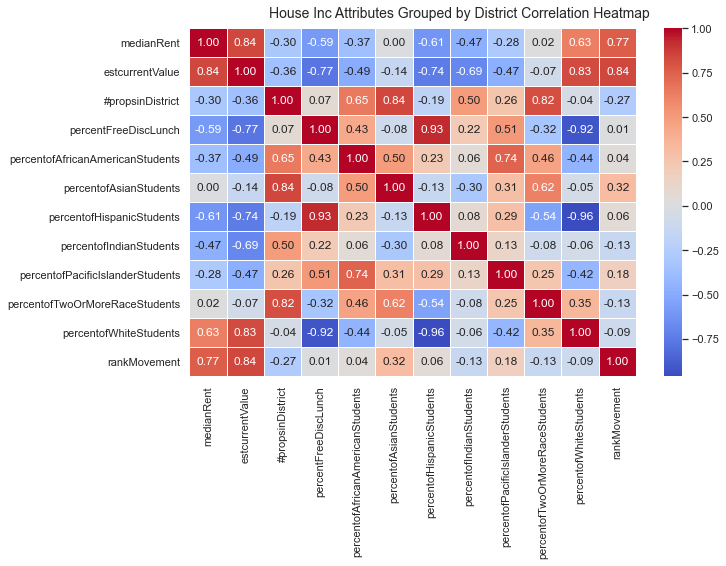

In [104]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df2.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap = "coolwarm", fmt='.2f', linewidth=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('House Inc Attributes Grouped by District Correlation Heatmap', fontsize=14)